# Imports for model running

In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import sagemaker
import boto3

import io
import sagemaker.amazon.common as smac

import os

### Import dataset

In [9]:
insurance_df = pd.read_csv('Data for HT.csv')

In [10]:
#preview the first 5 rows of the data
insurance_df.head()

,ID,Age,Gender,BMI,Doctor visits over 12 months,Av. Daily Steps,Smoking Status,Alcohol (Freq),Drugs Freq(),Av. Daily Kcal In,Av. Daily Kcal Burn,Av. Sleep per Day,Long term health cond.,Exercise Type,Exercise Intensity,Assured Cost,Insurance Cost
0,5000,28,Male,31.2,2,4866,Unknown,Rare,NaN,3100,2500,8.0,2,Fencing,Moderate,NaN,20978
1,5001,50,Male,34.2,4,6411,formerly smoked,Rare,NaN,2500,2500,7.0,0,Rugby/American Football,Moderate,NaN,6170
2,5002,68,Female,40.4,4,4509,formerly smoked,Daily,NaN,1900,2100,7.0,2,High Intensity Fitness,Extreme,NaN,28382
3,5003,51,Female,22.9,2,6214,Unknown,Rare,NaN,1900,2100,8.0,0,None,No,NaN,27148
4,5004,44,Male,26.5,2,4938,never smoked,No,NaN,2500,2500,7.0,0,Boxing,Extreme,NaN,29616


In [11]:
#check if the dataset cells contain any null values within any columns
insurance_df.isnull().sum()

ID                                  0
Age                                 0
Gender                              0
BMI                               990
Doctor visits over 12 months        0
Av. Daily Steps                     0
Smoking Status                      0
Alcohol (Freq)                      0
Drugs Freq()                    25000
Av. Daily Kcal In                   0
Av. Daily Kcal Burn                 0
Av. Sleep per Day                   0
Long term health cond.              0
Exercise Type                       0
Exercise Intensity                  0
Assured Cost                    25000
Insurance Cost                      0
dtype: int64

### Dataset Preprocessing and Data Augmentation

##### Since some columns contain non numerical data, convert all the columns to numerical which will reflect the values respectfully

##### GENDER
[Male = 0 | Female = 1]

In [12]:
insurance_df['Gender'] = insurance_df['Gender'].apply(lambda x: 0 if x == 'Male' else 1)

##### Smoking Status
[never smoked = 0 | formerley smoked = 1 | smokes = 2 | unknown = 3]

In [13]:
def condition_s(j):
    if j == 'never smoked':
        return 0
    elif j == 'formerly smoked':
        return 1
    elif j == 'smokes':
        return 2
    else:
        return 3


insurance_df['Smoking Status'] = insurance_df['Smoking Status'].apply(condition_s)

##### Alchohol (Freq)
[No = 0 | Rare = 1 | Daily = 2]

In [14]:
def condition_al(al):
    if al == 'No':
        return 0
    elif al == 'Rare':
        return 1
    else:
        return 2


insurance_df['Alcohol (Freq)'] = insurance_df['Alcohol (Freq)'].apply(condition_al)

##### Exercise Intensity 
[None = 0 | Moderate = 1 | Extreme = 2]

In [15]:
def condition_i(i):
    if i == 'No':
        return 0
    elif i == 'Moderate':
        return 1
    else:
        return 2


insurance_df['Exercise Intensity'] = insurance_df['Exercise Intensity'].apply(condition_i)

##### Drop the columns that are not relevant for fitting the model or have not been obtained

In [16]:
insurance_df = insurance_df.drop(columns=['Exercise Type'])
#insurance_df = insurance_df.drop(columns=['Av. Sleep per Day'])
#insurance_df = insurance_df.drop(columns=['Av. Daily Kcal In'])
insurance_df = insurance_df.drop(columns=['Drugs Freq()'])
#insurance_df = insurance_df.drop(columns=['Av. Daily Kcal Burn'])
insurance_df = insurance_df.drop(columns=['Assured Cost'])

### Drop the rows that will cause issue with taining the model, blank values or NaN

In [17]:
insurance_df = insurance_df.dropna()

### Create the testing and training data for the model at a 20-80 split respectively

In [18]:
#Create a dataset with all augmented data without the insurance cost column for training and testing
X = insurance_df.drop(columns=['Insurance Cost'])
#use y as the ground truth for all corresponding values in X
y = insurance_df['Insurance Cost']

#Reshape the datasets so that they can be used in the model
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

y = y.reshape(-1, 1)

#split the data to 20-80 for testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [20]:
X.shape


(24010, 13)

In [21]:
y.shape

(24010, 1)

In [22]:
#Start a sagemaker session and 

sagemaker_session = sagemaker.Session()

################# MUST BE CHANGED FOR FINAL IMPLEMENTATION #####################
bucket = 'sagemaker-hacker-2'
prefix = 'linear_learner'

role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::828659721679:role/service-role/AmazonSageMaker-ExecutionRole-20220807T193151


### Ensure y_train is in vector format

In [23]:
y_train = y_train[:,0]

#### Create a buffer for the training data to go to

In [24]:
buf = io.BytesIO()
#write training data to buffer
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)
buf.seek(0)

0

##### Store the training data in a specified folder #PLACEHOLDER - hack-train-data# in a specified s3 bucket

In [26]:
key = 'hack-train-data'

boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

ValueError: I/O operation on closed file.

In [27]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training uploaded will be uploaded to {}'.format(output_location))

Training uploaded will be uploaded to s3://sagemaker-hacker-2/linear_learner/output


In [28]:
#Specify sagemaker algorithm linear-learner

from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'linear-learner')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [45]:
#use ml.t3.medium as it is part of the free tier for sagemaker

linear = sagemaker.estimator.Estimator(container,
                                       role,
                                       train_instance_count = 1,
                                       train_instance_type = 'ml.m5.4xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session)

#features depend on the number of columns, since we have 11, use 11
#num_models runs the model 32 times, so you can pick the best one
linear.set_hyperparameters(feature_dim = 13,
                          predictor_type = 'regressor',
                          mini_batch_size = 100,
                          epochs = 100,
                          num_models = 32,
                          loss = 'absolute_loss')

linear.fit({'train': s3_train_data})

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2022-08-12 10:26:10 Starting - Starting the training job...ProfilerReport-1660299970: InProgress
...
2022-08-12 10:26:54 Starting - Preparing the instances for training......
2022-08-12 10:27:57 Downloading - Downloading input data...
2022-08-12 10:28:34 Training - Downloading the training image......
2022-08-12 10:29:35 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/12/2022 10:29:30 INFO 140513397925696] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias

#### Showcase predictions result of the model

In [46]:
linear_regressor = linear.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------!

In [47]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y)

In [48]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

linear_regressor.serializer = CSVSerializer()
linear_regressor.deserializer = JSONDeserializer()

In [49]:
result = linear_regressor.predict(X_test)

In [50]:
predictions = np.array([r['score'] for r in result['predictions']])

In [51]:
#set up variables to use for prediction analysis
y_predict_orig = scaler_y.inverse_transform(predictions)
y_test_orig = scaler_y.inverse_transform(y_test)

In [52]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

#Root Means Squared Error
RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_predict_orig)),'.3f'))
#Means Squared Error
MSE = mean_squared_error(y_test_orig, y_predict_orig)
#Mean Absolute Error
MAE = mean_absolute_error(y_test_orig, y_predict_orig)
#R-Squared Score
r2 = r2_score(y_test_orig, y_predict_orig)

In [53]:
print(RMSE)
print(MSE)
print(MAE)
print(r2)

14314.469
204904010.90548843
11828.871662146004
-0.003346954726760165


In [74]:
import numpy as np
import pandas as pd
# calculate correlation
insurance_df[np.array(insurance_df.columns)].corr()
# cols = ['happiness_score', 'gdp_per_capita','social_support', 'life_expectancy', 'freedom', 'generosity','perceptions_of_corruption']
# happiness21[cols].corr()

,ID,Age,Gender,BMI,Doctor visits over 12 months,Av. Daily Steps,Smoking Status,Alcohol (Freq),Av. Daily Kcal In,Av. Daily Kcal Burn,Av. Sleep per Day,Long term health cond.,Exercise Intensity,Insurance Cost
ID,1.000000,0.000791,-0.003248,0.004144,-0.003212,0.001240,-0.007230,0.011288,0.003590,0.003248,-0.007182,-0.004456,0.005217,-0.001386
Age,0.000791,1.000000,0.001399,-0.015071,-0.000604,-0.000637,0.007252,-0.001123,-0.510040,-0.001399,-0.604436,-0.002633,0.002392,0.004289
Gender,-0.003248,0.001399,1.000000,-0.339040,-0.001926,0.009687,0.256579,0.006590,-0.737393,-1.000000,0.006251,-0.009133,-0.011362,0.002297
BMI,0.004144,-0.015071,-0.339040,1.000000,0.000522,-0.005696,-0.212700,-0.001043,0.256575,0.339040,0.007381,0.004565,0.001716,-0.008231
Doctor visits over 12 months,-0.003212,-0.000604,-0.001926,0.000522,1.000000,-0.157906,-0.004356,-0.003597,-0.000228,0.001926,-0.003289,-0.012374,0.022574,0.008267
Av. Daily Steps,0.001240,-0.000637,0.009687,-0.005696,-0.157906,1.000000,0.007172,0.032406,-0.012957,-0.009687,0.005884,-0.004300,-0.100786,-0.005218
Smoking Status,-0.007230,0.007252,0.256579,-0.212700,-0.004356,0.007172,1.000000,0.005374,-0.187945,-0.256579,-0.000387,-0.007916,-0.002910,0.007657
Alcohol (Freq),0.011288,-0.001123,0.006590,-0.001043,-0.003597,0.032406,0.005374,1.000000,-0.004991,-0.006590,-0.002592,-0.003023,0.017260,-0.006547
Av. Daily Kcal In,0.003590,-0.510040,-0.737393,0.256575,-0.000228,-0.012957,-0.187945,-0.004991,1.000000,0.737393,0.245470,0.008744,0.015246,-0.003940
Av. Daily Kcal Burn,0.003248,-0.001399,-1.000000,0.339040,0.001926,-0.009687,-0.256579,-0.006590,0.737393,1.000000,-0.006251,0.009133,0.011362,-0.002297


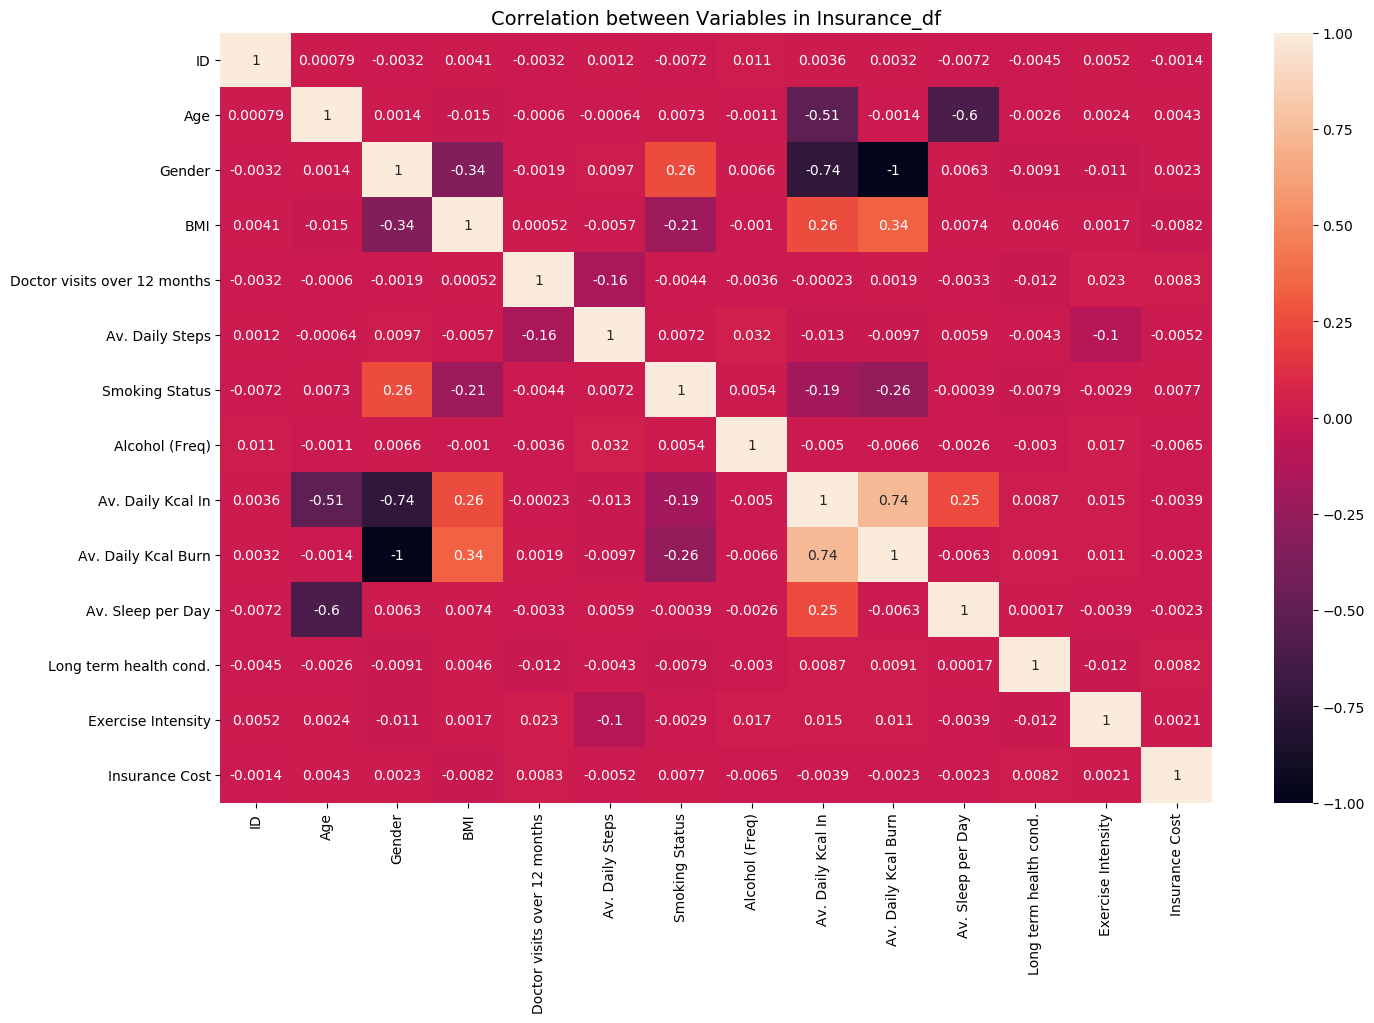

In [77]:
import seaborn as sns
# create heatmap for the calculated correlation
plt.figure(figsize=(16,10))
sns.heatmap(insurance_df[np.array(insurance_df.columns)].corr(),annot=True, fmt='.2g')

plt.title('Correlation between Variables in Insurance_df', fontsize=14)
plt.show()

# TERMINATE THE MODEL TO STOP RESOURCES BEING USED

In [ ]:
linear_regressor.delete_endpoint()